In [31]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [80]:
# install.packages(c("fastAdaboost", "caTools", "smotefamily", "dummies", "caret", "pROC", "stats", "fpc", "ggplot2", "gridExtra",  "ggpubr", 
#  "plotly", "dplyr", "MASS", "rootSolve", "lattice"))

In [123]:
import math
import plotly
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 

In [124]:
%%R
library("fastAdaboost") #Required to fit the AdaBoost Model
library("caTools") # Required to fit the LogitBoostModel
library("smotefamily") #Required to apply the SMOTE algorithm to expand the data
library("dummies") #Required for the 1-hot Encoding
library("caret") # Required for data separation and training/testing tasks
library("pROC") # Required to plot the ROC curves
library("stats") # Required for the computing efficient algorithm of minimization
library("fpc") 
library("ggplot2") #Required for plotting
library("gridExtra") 
library("ggpubr")
library("plotly")
library("dplyr")
library("MASS")
library("rootSolve")
library("lattice")

In [125]:
plotly.tools.set_credentials_file(username='LeonardoAlcivarWong', api_key='whWtTchoGGcxtT0tNk1a') #Access to the plotly API

In [126]:
%%R
options(expressions=500000) # Increasing the maximum number of iterations and depth of recursion available

In [127]:
def correlation_matrix(df):
    corr = df.corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11.7, 8.27))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    
    return sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

def boxdiag(df, x, title):  #Function to create boxplots using Plotly
    
    df_diag = df[[x, "diagnosis"]]
    df_positive = df_diag.loc[df_diag["diagnosis"]== "1"]
    df_negative = df_diag.loc[df_diag["diagnosis"]== "-1"]
    
    trace0 = go.Box(
        y =df_positive[x],
        name ='Altered Semen',
        jitter = 0.3,
        pointpos = -1.8,
        boxpoints = 'all',
        marker=dict(
            color='rgb(8, 81, 156)',
        ),
        boxmean="sd"
    )
    
    trace1 = go.Box(
        y=df_negative[x],
        name='Normal Semen',
        jitter = 0.3,
        pointpos = -1.8,
        boxpoints = 'all',
        marker=dict(
            color='rgb(10, 140, 208)',
        ),
        boxmean="sd"
    )
    
    layout = go.Layout(
        title = title
        )
    data1 = [trace0,trace1]
    fig = go.Figure(data=data1,layout=layout)
    return py.iplot(fig, filename = title)


def bardiag(df, x, title):  #Function to create barplots using plotly
    df_diag = relative_size(df, x, "diagnosis")
    #df_diag = data.groupby([x, "diagnosis"]).size().to_frame("size").reset_index()
    df_positive = df_diag.loc[df_diag["diagnosis"]== "1"]
    df_negative = df_diag.loc[df_diag["diagnosis"]== "-1"]
    
    trace1 = go.Bar(
        x=df_positive[x],
        y=df_positive["relative_size"],
        name='Altered Semen',
        marker=dict(
        color='rgb(8, 81, 156)'
    )
    )
    trace2 = go.Bar(
        x=df_negative[x],
        y=df_negative["relative_size"],
        name='Normal Semen',
        marker=dict(
        color='rgb(10, 140, 208)'
    )
    )

    data1 = [trace1, trace2]
    layout = go.Layout(
        title = title,
        barmode='group'
    )

    fig = go.Figure(data=data1, layout=layout)
    return py.iplot(fig, filename=title)

def histdiag(df, x, title): #Function to create histograms using Plotly
    
    df_diag = df[[x, "diagnosis"]]
    df_positive = df_diag.loc[df_diag["diagnosis"]== "1"]
    df_negative = df_diag.loc[df_diag["diagnosis"]== "-1"]
    
    trace1 = go.Histogram(
        x=df_positive[x],
        opacity=0.75,
        name='Altered Semen'
    )
    
    trace2 = go.Histogram(
        x=df_negative[x],
        opacity=0.75,
        name='Normal Semen'
    )

    data = [trace1, trace2]
    layout = go.Layout(barmode='stack',
                      title = title)
    fig = go.Figure(data=data, layout=layout)

    return py.iplot(fig, filename=title)

def relative_size(df, biggroup, smallgroup): #Function to create relative size of different groups in DF
    Biggroupsize = df.groupby([biggroup]).size().to_frame("size")
    Smallgroupsize = df.groupby([biggroup, smallgroup]).size().to_frame("size").reset_index().set_index(biggroup)
    Smallgroupsize['relative_size'] = Smallgroupsize['size'] / Biggroupsize['size'].reindex(Smallgroupsize.index)
    return Smallgroupsize.reset_index()

In [128]:
%%R
quadratic_loss <- function(u){
    return((1-u)^2)
    }

exp_loss <- function(u){
    return(exp(-u))
    }

log_loss <- function(u){
    return(log(1+exp(-u)))
}

hinge_loss <- function(u){
    return(pmax(0, 1-u))
}

f <- function(x, data, loss = hinge_loss, regularisation) { #General function we are trying to minimize (see Section X)
    y <- as.matrix(data[, ncol(data)]) 
    beta <- as.matrix(x)
    features <- as.matrix(cbind(1, data[-ncol(data)]))
    result <- mean(loss(y*(features%*%beta))) + (regularisation/2)*t(beta[-1])%*%beta[-1]
    return(result)
}

gradient_descent <- function(precision, stepsize, f, xg,  loss, regularisation, ...) { #gradient descent algorithm
    
    x1 <- xg - stepsize*t(gradient(f = f, x = xg, data = data, loss = loss, regularisation = regularisation))
    if (dist(rbind(t(x1),t(xg))) < precision) {
        return(x1)
    }
    
    else {
        return(gradient_descent(precision = precision ,stepsize = stepsize, f, xg=x1, data=data, loss=loss, regularisation = regularisation))
    }
}


sgd <- function(precision, stepsize, f, xg, loss, regularisation, ...) { #stochastic gradient descent algorithm
   
   data <- data[sample(nrow(data)),]
    for(i in 1:nrow(data)) {
        x1 <- xg - stepsize*t(gradient(f = f, x = xg, data = data[i,], loss = loss, regularisation = regularisation))
    }
    
    if (sum(abs(gradient(f = f, x = x1, data = data, loss = loss, regularisation = regularisation)))< precision) {
        return(x1)
    }
    
    else {
        return(sgd(precision = precision ,stepsize = stepsize, f, xg=x1, data=data, loss=loss, regularisation = regularisation))
    }
}

classDistribution <- function(dataset.name = NULL, table = NULL, class = ncol(table)) #Function to display distributions
{                                                                                     # of classes inside DF
    print(paste("Class Distribution:", dataset.name, sep = " "));
    print(prop.table(table(table[,class])))
    cat("\n");
}


# Large Margin Classifiers for Fertility Alterations:

### Applying Different Loss Functions and Methodologies To Predict Fertility

**Author**: Sixter Leonardo Alcivar Wong 

**Subject**: Statistical Modeling and Inference

**Professor**: Omiros Papaspiliopoulos

## Introduction

There has been a significant decrease in semen quality in the last two decades (Gil et al, 2012). Moreover, this decrease has been related to several environmental factors, lifestyles and childhood circumstances. It is therefore important the use and test of AI methods, especially classification methods, to detect good candidates based in few observations for semen donations, improving like that efficiency in the selection process.  

In this work, we will restrict ourselves to the use of large margin classification methods and some of its derivatives (boosting methods, support vector machines and logistic regression). Furthermore, we will deal to some solutions for the typical problems of medical datasets, i.e imbalanced categories and limited observations, concretely, we will focus ourselves on the use of the Synthetic Minority Over-Sampling Method proposed by Chawla (Chawla et al, 2002). 

Finally, we will discuss and compare the methods proposed and suggests imrpovements to be done in order to achieve better resulst.


## Data

The fertility dataset we will be analyzing is a fragment of the original one used by David Gil (Gil et al, 2012) that can be found in the UIC repository. 

The dataset counts with 100 observations (88 normal and 12 altered samples). The features included are: 

1. Season: Season in which the analysis was performed.
2. Age: Age at the time of the analysis, which range from 18 to 36 years normalized to the range 0-1.
3. Sitting: Hours spent sitting per day, which range form 1 to 16 normalized to the range 0-1.
4. Childhood Diseases: Dummy variable considering the presence of childhood diseases such as chicken pox, measles or polio.
5. Accident: Dummy variable considering the presence of a serious trauma.
6. Surgical Intervention: Dummy variable considering the presence of a recent surgical intervention.
7. High Fever: Categorical varibale considering the presence of high fevers in more than three months, less than three months or no fever. 
8. Alcohol: Categorical varibale analyzing alcohol consumption with categories: never, once a week, several times a week, every day and several times a day.
9. Smoking: Categorixal variable analyzing smoking frequency with categories: never, occasional and daily.
10. Diagnosis: Diagnosis of the semen quality (altered or normal).

In [129]:
%%R -o data 
data <- read.table("./fertility_Diagnosis.txt", sep = ",", header = FALSE) #Read the data and importing it as a DF
colnames(data) <- c("season", "age", "chdiseases", "accident", "sintervention", "hfever", "alcohol", "smoking", "sitting", "diagnosis")
data$season <- as.factor(data$season) #Transforming categorical variables into factors
data$chdiseases <- as.factor(data$chdiseases)
data$accident <- as.factor(data$accident)
data$sintervention <- as.factor(data$sintervention)
data$hfever <- as.factor(data$hfever)
data$alcohol <- as.factor(data$alcohol)
data$smoking <- as.factor(data$smoking)
data$diagnosis <- as.factor(data$diagnosis)


levels(data$season) <- c("winter", "spring", "summer", "fall") #Renaming the levels of the factor variables
levels(data$chdiseases) <- c(1, 0)
levels(data$accident) <- c(1, 0)
levels(data$sintervention) <- c(1,0)
levels(data$hfever) <- c("more3m", "less3m", "no")
levels(data$alcohol) <- c("VeryHigh", "High", "Medium", "Low", "VeryLow")
levels(data$smoking) <- c("Never", "Occasional", "Daily")
levels(data$diagnosis) <- c(-1, +1)

/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning:

from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.



## Descriptive Analytics

A first look into the data let us know some facts about the population studied:
1. In our sample of the original dataset, age range from 27 to 36 years, with an average age of 30 years.
2. As expected, extreme behaviours such as very high alcohol or smoking consumption are rare, implying that they migh be very little informative since any relation could be mere chance.
3. The average person in our sample sits for 7 hours a day. 
4. There is an importance imbalance between altered samples and normal ones, a problem that will be intensified when we divide the data into a training and testing set.

However, in order to better identify relations we will proceed by plotting the data.

In [39]:
%%R
summary(data)

    season        age        chdiseases accident sintervention    hfever  
 winter:28   Min.   :0.500   1:13       1:56     1:49          more3m: 9  
 spring:37   1st Qu.:0.560   0:87       0:44     0:51          less3m:63  
 summer: 4   Median :0.670                                     no    :28  
 fall  :31   Mean   :0.669                                                
             3rd Qu.:0.750                                                
             Max.   :1.000                                                
     alcohol         smoking      sitting       diagnosis
 VeryHigh: 1   Never     :56   Min.   :0.0600   -1:88    
 High    : 1   Occasional:23   1st Qu.:0.2500   1 :12    
 Medium  :19   Daily     :21   Median :0.3800            
 Low     :39                   Mean   :0.4068            
 VeryLow :40                   3rd Qu.:0.5000            
                               Max.   :1.0000            


In [40]:
data.describe(include = "all")

,season,age,chdiseases,accident,sintervention,hfever,alcohol,smoking,sitting,diagnosis
count,100,100.000000,100,100,100,100,100,100,100.000000,100
unique,4,NaN,2,2,2,3,5,3,NaN,2
top,spring,NaN,0,1,0,less3m,VeryLow,Never,NaN,-1
freq,37,NaN,87,56,51,63,40,56,NaN,88
mean,NaN,0.669000,NaN,NaN,NaN,NaN,NaN,NaN,0.406800,NaN
std,NaN,0.121319,NaN,NaN,NaN,NaN,NaN,NaN,0.186395,NaN
min,NaN,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,0.060000,NaN
25%,NaN,0.560000,NaN,NaN,NaN,NaN,NaN,NaN,0.250000,NaN
50%,NaN,0.670000,NaN,NaN,NaN,NaN,NaN,NaN,0.380000,NaN
75%,NaN,0.750000,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,NaN


In [41]:
bardiag(data, "season", "Diagnosis by Season")

The graph suggests that samples collected during the fall season have more chances to be altered when we doesn't take into account the factors. 

(The high frequency during summer is not significant since it just imply that one of the four samples collected was altered.)

In [42]:
bardiag(data, "alcohol", "Diagnosis by Alcohol Consumption")

Although very high and high alcohol consumption don't have any altered sample, this is due to the fact that we just have one sample for each category. Therefore, by focusing on the other categories, we can see an increasing percentage of altered samples when we increase alcohol consumption. 

In [43]:
bardiag(data, "smoking", "Diagnosis by Smonking Habits")

There seems to be a slight increase of altered sample as we increase the frequency of smoking, it should be taken carefully due to the sutility of the increase.

In [44]:
bardiag(data, "hfever", "Diagnosis by Fever Condition")

In this case, we should focus our attention on the jump between no fever and fever in less thatn three months (given that we only got 9 observations for more than three months), suggesting a relation between fevers and altered semen.

In [45]:
bardiag(data, "chdiseases", "Diagnosis by Childhood Conditions")

From the graph we can also see certain positive relation between chilhood diseases and the proportion of altered samples. 

In [46]:
bardiag(data, "accident", "Diagnosis by Accident Condition")

Accidents also seem to have an important role in determining the proportion of altered samples (since both conditions have similar sizes and the proportion increase is of 10%).

In [47]:
bardiag(data, "sintervention", "Diagnosis by Surgical Condition")

Contrary to the accident condition, a surgical intervention seems to decrease the percentage of altered samples, probably because of the procedures and the care a pacient have.

In [48]:
boxdiag(data, "age", "Diagnosis by Age")

In [49]:
boxdiag(data, "sitting", "Diagnosis by Hours Sitting")

When looking into the continuous variables age and hours sitting it seems that means tend to be bigger in the altered sample, nevertheless the plots suggest that by themselves these two variables are not informative.

In [50]:
x, y, z = data.age, data.sitting, data["diagnosis"].astype(int)

trace1 = go.Scatter(
    y = y,
    x = x,
    mode='markers',
    marker=dict(
        size=10,
        color = z, #set color equal to a variable
        colorscale='Viridis',
        showscale=True
    )
)
data1 = [trace1]

py.iplot(data1, filename='scatter-plot-with-colorscale')


Note: Age on the X axis and Sitting hours in the y axis.

Moreover, we can see a similar pattern when looking at both at the same time, although it seems that altered samples tend to be in higher values of both, the classes don't appear linearly separables in these two dimensions.

In [51]:
trace1 = go.Scatter3d(
    x= data.age,
    y= data.sitting,
    z= data.hfever,
    mode='markers',
    marker=dict(
        size=10,
        color=pd.to_numeric(data.diagnosis),                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)

trace2 = go.Scatter3d(
    x= data.age,
    y= data.sitting,
    z= data.chdiseases,
    mode='markers',
    marker=dict(
        size=10,
        color=pd.to_numeric(data.diagnosis),                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)

trace3 = go.Scatter3d(
    x= data.age,
    y= data.sitting,
    z= data.sintervention,
    mode='markers',
    marker=dict(
        size=10,
        color=pd.to_numeric(data.diagnosis),                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)

trace4 = go.Scatter3d(
    x= data.age,
    y= data.sitting,
    z= data.alcohol,
    mode='markers',
    marker=dict(
        size=10,
        color=pd.to_numeric(data.diagnosis),                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)

trace5 = go.Scatter3d(
    x= data.age,
    y= data.sitting,
    z= data.smoking,
    mode='markers',
    marker=dict(
        size=10,
        color=pd.to_numeric(data.diagnosis),                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)


trace6 = go.Scatter3d(
    x= data.age,
    y= data.sitting,
    z= data.accident,
    mode='markers',
    marker=dict(
        size=10,
        color=pd.to_numeric(data.diagnosis),                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)

trace7 = go.Scatter3d(
    x= data.age,
    y= data.sitting,
    z= data.season,
    mode='markers',
    marker=dict(
        size=10,
        color=pd.to_numeric(data.diagnosis),                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)






data1 = [trace1, trace2, trace3, trace4, trace5, trace6, trace7]

updatemenus = list([
    dict(type="buttons",
         active= 0,
         buttons=list([
            dict(label = 'High Fever',
                 method = 'update',
                 args = [{'visible': [True, False, False, False, False, False, False]},
                         {'title': 'High Fever'}]),
            dict(label = 'Childhood Diseases',
                 method = 'update',
                 args = [{'visible': [False, True, False, False, False, False, False]},
                         {'title': 'Childhood Diseases'}]),
            dict(label = 'Surgical Intervention',
                 method = 'update',
                 args = [{'visible': [False, False, True, False, False, False, False]},
                         {'title': 'Surgical Intervention'}]),
             
            dict(label = 'Alcohol',
                 method = 'update',
                 args = [{'visible': [False, False, False, True, False, False, False]},
                         {'title': 'Alcohol'}]
                ),
             
            dict(label = 'Smoking',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, True, False, False]},
                         {'title': 'Smoking Habits'}]
                ),
            
            dict(label = 'Accident',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, True, False]},
                         {'title': 'Accident'}]
                ),
             
            dict(label = 'Season',
                 method = 'update',
                 args = [{'visible': [False, False, False, False, False, False, True]},
                         {'title': 'Season'}]
                )
             ]),
    )
])

layout = dict(
    title = "3D Plot",
    showlegend=False,
    updatemenus = updatemenus
)

fig = dict(data=data1, layout=layout)
py.iplot(fig, filename='3d-scatter-colorscale')


Note: Age in the X axis and Sitting hours in the Y axis. The z-axis can be selected by clicking in one of the buttons.  

When comparing the two continuous variables with any of the categorical variables, no hyperplane seems to separate the data neither. Nevertheless, we should wait until see performance of the algorithms to understand the importance of this situation and possible solutions. 

### One-hot Encoding:

Before proceeding with the implementation of the large margin classifiers, we encoded the categorical variables into dummy variables.

In [130]:
%%R
# We normalize the data to have mean value equal 0 and variance equal to 1
data <- data %>% 
         mutate_at(vars(age, sitting), funs(as.vector(scale(.))))

In [131]:
%%R
data <- dummy.data.frame(data, names = c("season", "chdiseases", "accident", "sintervention", "hfever", "alcohol",
                                "smoking"))
# We delete one of the categories in order to avoid multicollinearity
data$seasonwinter <- NULL
data$chdiseases0 <- NULL
data$accident0 <- NULL
data$sintervention0 <- NULL
data$hfeverno<- NULL
data$alcoholVeryLow <- NULL
data$smokingNever <- NULL
data$diagnosis <- as.numeric(levels(data$diagnosis))[data$diagnosis]

In [91]:
%%R
summary(data)

  seasonspring   seasonsummer    seasonfall        age           
 Min.   :0.00   Min.   :0.00   Min.   :0.00   Min.   :-1.393027  
 1st Qu.:0.00   1st Qu.:0.00   1st Qu.:0.00   1st Qu.:-0.898461  
 Median :0.00   Median :0.00   Median :0.00   Median : 0.008243  
 Mean   :0.37   Mean   :0.04   Mean   :0.31   Mean   : 0.000000  
 3rd Qu.:1.00   3rd Qu.:0.00   3rd Qu.:1.00   3rd Qu.: 0.667664  
 Max.   :1.00   Max.   :1.00   Max.   :1.00   Max.   : 2.728355  
  chdiseases1     accident1    sintervention1  hfevermore3m   hfeverless3m 
 Min.   :0.00   Min.   :0.00   Min.   :0.00   Min.   :0.00   Min.   :0.00  
 1st Qu.:0.00   1st Qu.:0.00   1st Qu.:0.00   1st Qu.:0.00   1st Qu.:0.00  
 Median :0.00   Median :1.00   Median :0.00   Median :0.00   Median :1.00  
 Mean   :0.13   Mean   :0.56   Mean   :0.49   Mean   :0.09   Mean   :0.63  
 3rd Qu.:0.00   3rd Qu.:1.00   3rd Qu.:1.00   3rd Qu.:0.00   3rd Qu.:1.00  
 Max.   :1.00   Max.   :1.00   Max.   :1.00   Max.   :1.00   Max.   :1.00  
 alcoh

### Sampling for training and testing data

In [132]:
%%R -o training,test 
set.seed(134)
class <- length(data)

# Set number of folds.
k <- 1

# Variable that points to active fold.
j <- 1

# Perform stratified bootstrapping (keep 70% of observations for training and 50% for testing).
indices.training <- createDataPartition(data[,class], 
										times = k, 
										p =.70, 
										list = FALSE)
# Get training and test set.
training <- data[indices.training[,j],]
test  <- data[-indices.training[,j],]

# Print class distribution.
cat("\n\n")
classDistribution(dataset.name = "data",
				  table = data,
				  class = length(data))

classDistribution(dataset.name = "training",
				  table = training,
				  class = class)

classDistribution(dataset.name = "test",
				  table = test,
				  class = class)



[1] "Class Distribution: data"

  -1    1 
0.88 0.12 

[1] "Class Distribution: training"

       -1         1 
0.8857143 0.1142857 

[1] "Class Distribution: test"

       -1         1 
0.8666667 0.1333333 



Note: As we can see, class distributions are similar between the training and the testing sets.

In [56]:
x, y, z = training.age, training.sitting, training["diagnosis"].astype(int)

trace1 = go.Scatter(
    y = y,
    x = x,
    mode='markers',
    marker=dict(
        size=10,
        color = z, #set color equal to a variable
        colorscale='Viridis',
        showscale=True
    )
)
data1 = [trace1]

py.iplot(data1, filename='training')

Note: As before, data don't seem to be linearly separable on the sitting and age variables. Moreover, we can see a clear imbalance between the two classes.

## Fitting Possible Models

### Theoretical Background:

The classification problem using large margin classifiers is defined as follows.
Given a set of attributes $X = \{X_1, ... , X_n\}$ and a vector $Y$ of classes s.t. $Y \in \{-1, 1\}$, and a training data of the form $D_n = \{(x_i,y_i), i=1,...,n\}$ where the pairs $(x_i, y_i)$ are viewed as independent identically distributed outcomes of $(X , Y)$ with an unknown distribution $P_{XY}$. We want to find a prediction rule $\phi: X \Rightarrow Y$ of the form $\phi(X) = sign\{f(X)\}$ where:

$$
f(X) = h(X)^t \beta + \beta_0
$$

Where $h(X)$ is a weak rule classifier. For this first part, we will consider that $h(X) = X$, although this will change with the boosting algorithms. 
This prediction rule must minimize the probability of misclassification, therefore:

$$
argmin P[y \neq \phi(X)] = E[1_{[y\phi(X) < 0]}] \approx \frac{1}{N} \sum_{i} 1_{[y_i \phi(X_i) < 0]} = \frac{1}{N}\sum_{i} 1_{[y_i(h(X)^t \beta + \beta_0)]}
$$

Nevertheless, this problem is NP hard, therefore we approximate this by substituting the indicator function with a convex loss function, transforming the problem into:

$$
argmin E[L[y_i(h(X)^t \beta + \beta_0)]] \approx \frac{1}{N}\sum_{i}L[y_i(h(X)^t \beta + \beta_0)] + \frac{\lambda}{2} \beta^t \beta
$$

Where this expected loss is known as empirical risk.


### Simple models:

As we stated before, for this first section, we will consider $h(X) = X$ and different loss functions which are applied in other algorithms. In fact, when considering $h(X) = X$ and loss function equal to the hinge loss, we are just considering a Support Vector Machine (SVM) of soft margin (allowing for some misclassification given data not linearly separable). 
Moreover, as stated by Yoonkyung Lee (2014), by applying different loss functions we allow for different asymptotic behaviours of the resulting discriminant functions. 

In [133]:
%%R

#We fit the models with different regularization parameters
#To see the changes in the weights assigne to each variables
regularization_graph <- function(data, loss) {
    
    evolution <- data.frame() 
    
    for (i in 1:100) {
        x0 = rep(0, ncol(data))
        opt <- nlm(f, p = x0, data = data, loss = loss, regularisation = i/50)
        evolution <- rbind(opt$estimate, evolution)
        
    }
    
    colnames(evolution) = c("constant", "seasonspring", "seasonsummer", "seasonfall", "age", "chdiseases1", "accident1","sintervention1", "hfever<3m", "hfever3>m", "alcoholVH", "alcoholH", "alcoholM",
                                    "alcoholL", "smokingO", "smokingD", "sitting")
    print(summary(evolution[-1]))
    return(evolution)
}


#### Internal Cross-Validation: (Grid - Search)

In [134]:
%%R
# After obtaining different models with different lambda parameters
# we use internal cross-validation to identify the best predictive model.
grid_search <- function(data, estimators){

grid <- data.frame()
for (i in 1:100) {
    predictions <- as.matrix(cbind(1, data[-ncol(data)]))%*%t(as.matrix(estimators[i,]))
    predictions <- ifelse(predictions >= 0, 1, -1)
    real_values <- data$class 
    accuracy <- ifelse(predictions == real_values, 1, 0)
    grid <- rbind(sum(accuracy), grid)
}

print("Optimal regularization parameter")
print(which.max(grid[,1])/50)
print("Accuracy of the model")
print(grid[which.max(grid[,1]),]/nrow(data))
return(estimators[101-which.max(grid[,1]), ])
}


#### Hinge Loss with the Original Training Set

Firstly, we will try to use this simple optimization algortihm with hinge loss. Which should behave as a support vector machine since it optimizes the same convex problem.

In [59]:
%%R
set.seed(134)
SMALLHINGE <- regularization_graph(data = training, loss = hinge_loss)

  seasonspring         seasonsummer          seasonfall       
 Min.   :-0.0001754   Min.   :-4.008e-04   Min.   :0.0003562  
 1st Qu.: 0.0001137   1st Qu.:-2.816e-06   1st Qu.:0.0009725  
 Median : 0.0002484   Median :-8.919e-07   Median :0.0014380  
 Mean   : 0.0008644   Mean   :-1.153e-05   Mean   :0.0040840  
 3rd Qu.: 0.0005789   3rd Qu.: 4.800e-09   3rd Qu.:0.0027829  
 Max.   : 0.0197700   Max.   : 2.189e-05   Max.   :0.0780109  
      age             chdiseases1           accident1        
 Min.   :0.0001482   Min.   :-0.0104947   Min.   :0.0000368  
 1st Qu.:0.0004235   1st Qu.:-0.0004723   1st Qu.:0.0003925  
 Median :0.0006363   Median :-0.0002089   Median :0.0006034  
 Mean   :0.0017113   Mean   :-0.0005529   Mean   :0.0017734  
 3rd Qu.:0.0012665   3rd Qu.:-0.0001047   3rd Qu.:0.0012903  
 Max.   :0.0312601   Max.   : 0.0001784   Max.   :0.0344080  
 sintervention1         hfever<3m           hfever3>m        
 Min.   :-9.551e-03   Min.   :0.0002898   Min.   :0.0002849  
 

In [115]:
%%R -o SMALLHINGE_ESTIMATOR 
SMALLHINGE_ESTIMATOR <- grid_search(training, SMALLHINGE)
SMALLHINGE_ESTIMATOR 

[1] "Optimal regularization parameter"
[1] 0.02
[1] "Accuracy of the model"
[1] 0
     constant seasonspring seasonsummer seasonfall        age chdiseases1
100 -1.189427   0.01976996 -8.52569e-05 0.07801095 0.03126015 -0.01049468
     accident1 sintervention1  hfever<3m  hfever3>m   alcoholVH      alcoholH
100 0.03440797   -0.009551192 0.03844915 0.03245808 0.001098883 -4.287311e-05
     alcoholM  alcoholL    smokingO    smokingD    sitting
100 0.1179127 0.1057815 -0.03360867 0.003392961 0.06066547


/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning:

from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.



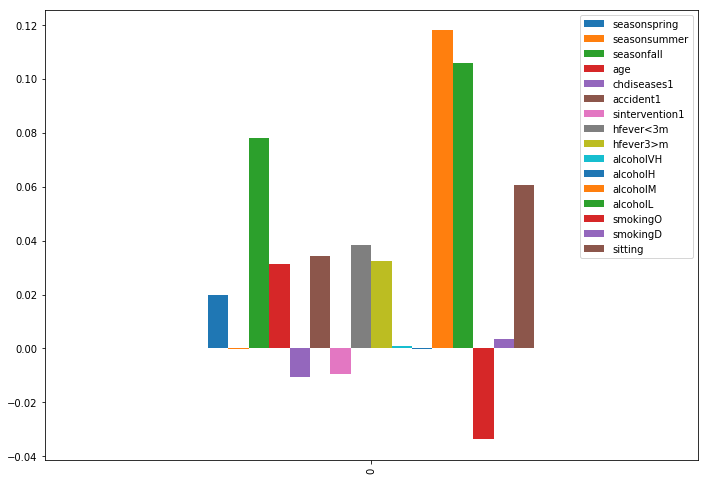

In [122]:
SMALLHINGE_ESTIMATOR[SMALLHINGE_ESTIMATOR.columns[1:]].plot.bar(figsize=(11.7, 8.27)) #Size of the betas

As we can see, alcohol consumption and sitting hours tend to have important effects on the classification process.

In [61]:
%%R
SMALLHINGE_PREDICTION <- as.matrix(cbind(1, test[-ncol(test)]))%*%t(as.matrix(SMALLHINGE_ESTIMATOR))
SMALLHINGE_PREDICTION <- ifelse(SMALLHINGE_PREDICTION >= 0, 1, -1)
confusionMatrix(as.factor(SMALLHINGE_PREDICTION), as.factor(test$diagnosis), positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction -1  1
        -1 26  4
        1   0  0
                                          
               Accuracy : 0.8667          
                 95% CI : (0.6928, 0.9624)
    No Information Rate : 0.8667          
    P-Value [Acc > NIR] : 0.6292          
                                          
                  Kappa : 0               
 Mcnemar's Test P-Value : 0.1336          
                                          
            Sensitivity : 0.0000          
            Specificity : 1.0000          
         Pos Pred Value :    NaN          
         Neg Pred Value : 0.8667          
             Prevalence : 0.1333          
         Detection Rate : 0.0000          
   Detection Prevalence : 0.0000          
      Balanced Accuracy : 0.5000          
                                          
       'Positive' Class : 1               
                                          


However, as we can see, due to the imbalance in the dataset, the algorithm just predicts all the observations to be normal. In order to solve this imbalance we will introduce the Synthetic Minority Over-Sampling Technique before proceeding.

#### Oversampling using SMOTE (Synthetic Minority Over-Sampling Technique) Algorithm

In order to provide the algorithm with enough altered observations SMOTE generates "synthetic" ones along the line segments joining the k minority class nearest neighbours (for our work we just considered 5 nearest neighbours) in the feature space. By doing so, the algorithm forces the decision region of the minority class to be more general and better defined. Moreover, although by doing so we will be biasing our algorithm towards the minority class and it will generate altered predictions even in locations that might be erroneous, in general, as shown by Chawla (Chawla et al. 2002), it increases the accuracy of the classifiers when determining minority observations and improve AUC estatistics in similar datasets as ours (Breasts cancer and Oil datasets).

In fact, taking into account the area we are considering (medical tests), we consider more important an increase of the recall parameter rather than in the precision parameter, since type 2 errors are related to dramatic results whereas type 1 errors are not so relevant. 




##### Pseudocode:

**Input**: Number of minority class samples T, amount of the increase of observations N%, number of nearest neighbours to be considered.

**Output**: Increased dataset.

**if** N < 100 

$\quad$ **then** Randomize the T minority class samples

$\quad$ $\quad$ T = (N/100)*T
$\quad$ $\quad$ N = 100

**endif**

N = round (N/100)

k = Number of nearest neighbours

**while** N $\neq$ 0

$\quad$ Choose one of the k nearest neighbours of i

$\quad$ $\quad$ **for** all features:

$\quad$ $\quad$ $\quad$ Compute the difference between observation i and one of its KNN. Compute also a random number between 0 and 1. Finally create a synthetic point adding the difference times the number calculated before to the point i.

$\quad$ $\quad$ **endfor**

$\quad$ i++

$\quad$ N = N-1

**endwhile**
**return** new DF





As we can see, the algorithm is meant to continuous features, and although there exists a version for categorical variables (SMOTE-N) we decided to just round the answers for simplicity in the implementation.

In [135]:
%%R -o expanded_training
set.seed(234)
expanded_training <- SMOTE(training[-ncol(training)], training[ncol(training)]) #Applying the SMOTE algorithm to expand the dataset
expanded_training <- expanded_training$data
expanded_training <- expanded_training %>%  #rounding categorical variables
                 mutate_at(vars(seasonspring, seasonsummer, seasonfall, chdiseases1, accident1,
                       sintervention1, hfevermore3m, hfeverless3m, alcoholVeryHigh, alcoholHigh, 
                       alcoholMedium, alcoholLow, smokingOccasional, smokingDaily), funs(round(., 0)))

In [136]:
%%R
expanded_training$class <- as.numeric(expanded_training$class)

In [97]:
expanded_training.tail()

,seasonspring,seasonsummer,seasonfall,age,chdiseases1,accident1,sintervention1,hfevermore3m,hfeverless3m,alcoholVeryHigh,alcoholHigh,alcoholMedium,alcoholLow,smokingOccasional,smokingDaily,sitting,class
113,1.0,0.0,0.0,1.162230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.143780,-1
114,0.0,1.0,0.0,0.914947,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.860562,-1
115,0.0,0.0,0.0,0.008243,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.500013,-1
116,0.0,0.0,0.0,-0.486323,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.500013,-1
117,0.0,0.0,0.0,-0.239040,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.163120,-1


In [65]:
x, y, z = expanded_training.age, expanded_training.sitting, expanded_training["class"].astype(int)

trace1 = go.Scatter(
    y = y,
    x = x,
    mode='markers',
    marker=dict(
        size=10,
        color = z, #set color equal to a variable
        colorscale='Viridis',
        showscale=True
    )
)
data1 = [trace1]

py.iplot(data1, filename='expanded_training')

Note: Age in the X-axis. Sitting hours in the Y-axis.

As we can see, by expanding using the SMOTE algorithm (we have created 48 new observations) the regions of altered and normal are more visible, in fact, given the nature of SMOTE of creating observations in the lines between the minority points, now there is visible a possible linear separation in the space generated by the age and the sitting features. 

##### Hinge Loss using the Expanded Training Set

In [137]:
%%R -o HINGE_NOCONST
set.seed(134)
HINGE <- regularization_graph(data = expanded_training, loss = hinge_loss)
HINGE_NOCONST <- HINGE[-1]

  seasonspring       seasonsummer          seasonfall           age         
 Min.   :-0.19827   Min.   :-0.1372085   Min.   :0.05085   Min.   :0.06840  
 1st Qu.:-0.06317   1st Qu.:-0.0158448   1st Qu.:0.06757   1st Qu.:0.09091  
 Median :-0.03357   Median :-0.0082290   Median :0.10070   Median :0.13547  
 Mean   :-0.04721   Mean   :-0.0167381   Mean   :0.14988   Mean   :0.21730  
 3rd Qu.:-0.02252   3rd Qu.:-0.0055577   3rd Qu.:0.19752   3rd Qu.:0.26572  
 Max.   :-0.01695   Max.   : 0.0004433   Max.   :0.48631   Max.   :0.91258  
  chdiseases1        accident1       sintervention1       hfever<3m      
 Min.   :0.04661   Min.   :0.02119   Min.   :-0.11770   Min.   :0.03814  
 1st Qu.:0.06194   1st Qu.:0.02816   1st Qu.:-0.06279   1st Qu.:0.05068  
 Median :0.09231   Median :0.04196   Median :-0.03644   Median :0.07552  
 Mean   :0.12894   Mean   :0.07786   Mean   :-0.03744   Mean   :0.15261  
 3rd Qu.:0.18106   3rd Qu.:0.08230   3rd Qu.:-0.02576   3rd Qu.:0.14814  
 Max.   :0.41909 

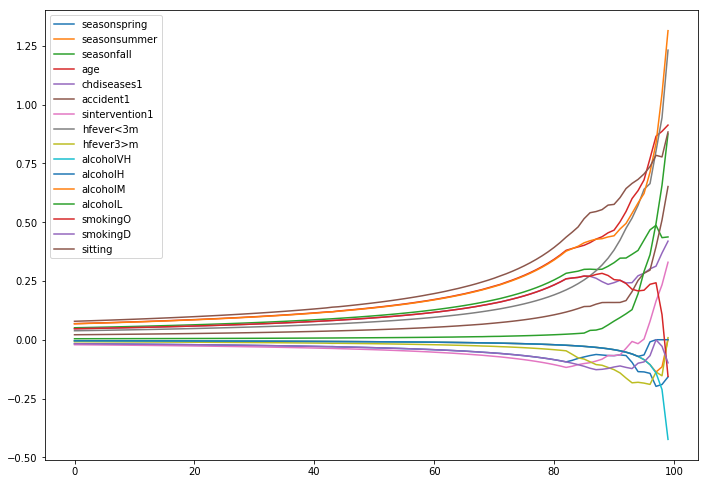

In [138]:
HINGE_NOCONST.plot.line(figsize=(11.7, 8.27))

By observing the absolute size of the betas as the regularization parameter increases (from right to left) we can observe the relevant variables in determining the class of the sample. Using the Hinge loss, we can see that hours sitting, surgical interventions, alcohol consumption and age are important determinants of the class in the directions we estated by looking into the graphs. Moreover, the lambda parameter is the minimum one, implying that the data is almost linearly separable, approximating SVM with a hard-margin. 

In [139]:
%%R -o HINGE_ESTIMATOR 
HINGE_ESTIMATOR <- grid_search(expanded_training, HINGE)
HINGE_ESTIMATOR 

[1] "Optimal regularization parameter"
[1] 0.02
[1] "Accuracy of the model"
[1] 0.8050847
     constant seasonspring seasonsummer seasonfall       age chdiseases1
100 -1.751973    -0.158224 0.0004433203  0.4370078 0.9125828    0.419094
    accident1 sintervention1 hfever<3m   hfever3>m  alcoholVH     alcoholH
100 0.6513383      0.3294211  1.231274 0.008766341 -0.4236021 2.835685e-05
    alcoholM alcoholL   smokingO    smokingD   sitting
100 1.313945 0.874972 -0.1555113 -0.09826787 0.8832283


/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning:

from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.



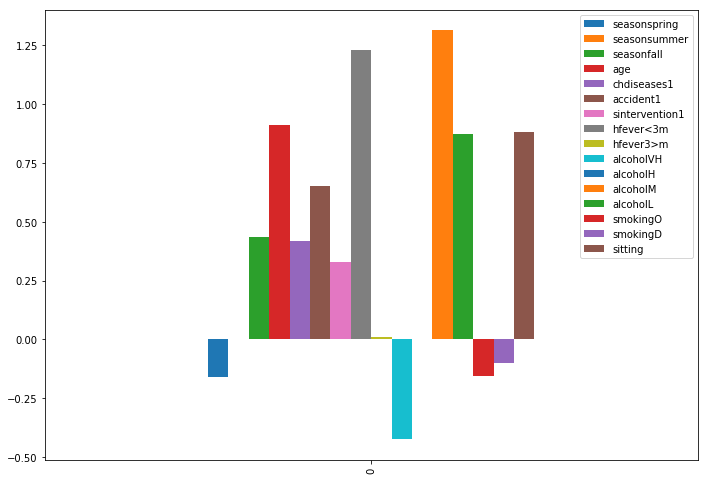

In [140]:
HINGE_ESTIMATOR[HINGE_ESTIMATOR.columns[1:]].plot.bar(figsize=(11.7, 8.27)) #Size of the betas

In [111]:
%%R
HINGE_PREDICTION <- as.matrix(cbind(1, test[-ncol(test)]))%*%t(as.matrix(HINGE_ESTIMATOR))
HINGE_PREDICTION <- ifelse(HINGE_PREDICTION >= 0, 1, -1)
confusionMatrix(as.factor(HINGE_PREDICTION), as.factor(test$diagnosis), positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction -1  1
        -1 17  2
        1   9  2
                                          
               Accuracy : 0.6333          
                 95% CI : (0.4386, 0.8007)
    No Information Rate : 0.8667          
    P-Value [Acc > NIR] : 0.99974         
                                          
                  Kappa : 0.0884          
 Mcnemar's Test P-Value : 0.07044         
                                          
            Sensitivity : 0.50000         
            Specificity : 0.65385         
         Pos Pred Value : 0.18182         
         Neg Pred Value : 0.89474         
             Prevalence : 0.13333         
         Detection Rate : 0.06667         
   Detection Prevalence : 0.36667         
      Balanced Accuracy : 0.57692         
                                          
       'Positive' Class : 1               
                                          


By using the expanded the training set now the algorithm, although misclassifying some of the normal observations, is able to detect half of the altered samples, improving its recall by sacrificing some of its precision.

##### Quadratic Loss using the Expanded Training Set

The use of the quadratic loss function is in fact an extension of the previous basic model known as Smooth SVM (in this case simplified since the Smooth SVM uses the square of the hinge loss). In contrast with the previouse loss function this one is differentiable everywhere which allow faster and more efficient methods of optimization. As stated by Lee (2000), it perform better in terms of computing time and ten-fold testing correctness percentage in cross validation.

In [141]:
%%R -o QUADRATIC_NOCONST
set.seed(134)
QUADRATIC <- regularization_graph(data = expanded_training, loss = quadratic_loss)
QUADRATIC_NOCONST <- QUADRATIC[-1]

  seasonspring       seasonsummer        seasonfall           age        
 Min.   :-0.04921   Min.   :-0.02497   Min.   :0.09208   Min.   :0.1240  
 1st Qu.:-0.02529   1st Qu.:-0.02104   1st Qu.:0.11360   1st Qu.:0.1523  
 Median :-0.02362   Median :-0.01644   Median :0.14857   Median :0.1973  
 Mean   :-0.02340   Mean   :-0.01583   Mean   :0.17372   Mean   :0.2268  
 3rd Qu.:-0.02080   3rd Qu.:-0.01327   3rd Qu.:0.21576   3rd Qu.:0.2802  
 Max.   :-0.01838   Max.   : 0.06885   Max.   :0.35533   Max.   :0.4600  
  chdiseases1        accident1       sintervention1       hfever<3m      
 Min.   :0.06972   Min.   :0.02222   Min.   :-0.03141   Min.   :0.06934  
 1st Qu.:0.08403   1st Qu.:0.02788   1st Qu.:-0.03084   1st Qu.:0.08755  
 Median :0.10633   Median :0.03839   Median :-0.02938   Median :0.11918  
 Mean   :0.11992   Mean   :0.05975   Mean   :-0.01666   Mean   :0.16493  
 3rd Qu.:0.14707   3rd Qu.:0.06610   3rd Qu.:-0.02002   3rd Qu.:0.19009  
 Max.   :0.21669   Max.   :0.29617   M

/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning:

from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.



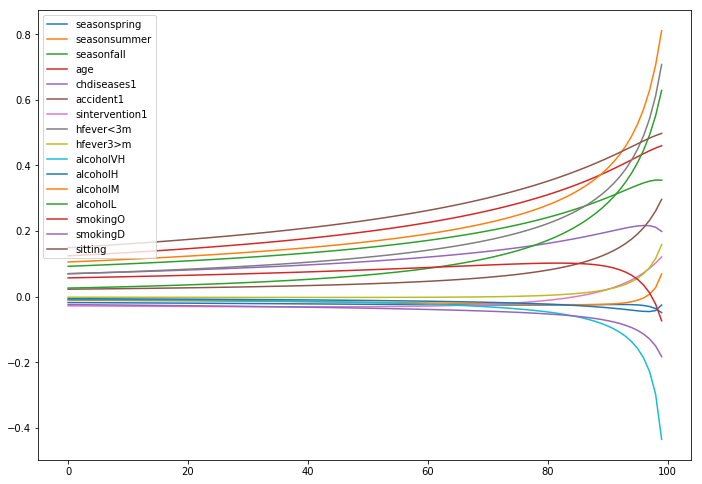

In [142]:
QUADRATIC_NOCONST.plot.line(figsize=(11.7, 8.27))

In [143]:
%%R -o QUADRATIC_ESTIMATOR
QUADRATIC_ESTIMATOR <- grid_search(expanded_training, QUADRATIC)
QUADRATIC_ESTIMATOR

[1] "Optimal regularization parameter"
[1] 0.12
[1] "Accuracy of the model"
[1] 0.8050847
     constant seasonspring seasonsummer seasonfall       age chdiseases1
95 -0.8121425  -0.02480282  -0.01585104  0.3323226 0.4171801   0.2123282
   accident1 sintervention1 hfever<3m  hfever3>m alcoholVH    alcoholH
95 0.1752015     0.05057027 0.4164825 0.04534406 -0.137741 -0.04166404
    alcoholM  alcoholL   smokingO    smokingD   sitting
95 0.4894571 0.3768059 0.06481976 -0.09480875 0.4570547


/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning:

from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.



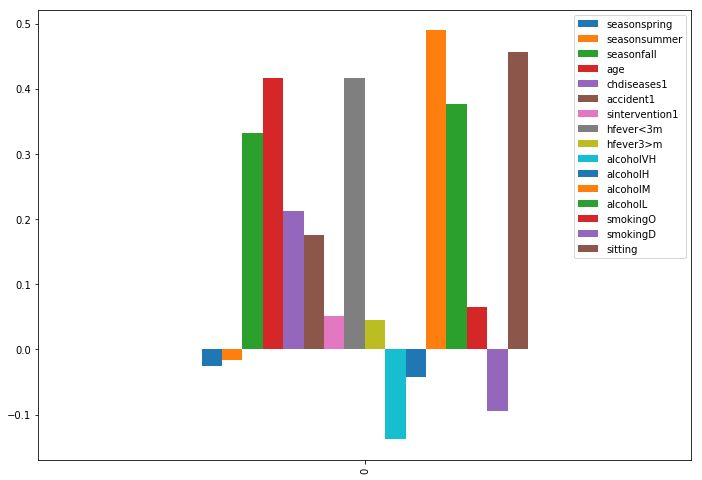

In [144]:
QUADRATIC_ESTIMATOR[QUADRATIC_ESTIMATOR.columns[1:]].plot.bar(figsize=(11.7, 8.27)) #Size of the betas

In [115]:
%%R
QUADRATIC_PREDICTION <- as.matrix(cbind(1, test[-ncol(test)]))%*%t(as.matrix(QUADRATIC_ESTIMATOR))
QUADRATIC_PREDICTION <- ifelse(QUADRATIC_PREDICTION >= 0, 1, -1)
confusionMatrix(as.factor(QUADRATIC_PREDICTION), as.factor(test$diagnosis), positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction -1  1
        -1 17  2
        1   9  2
                                          
               Accuracy : 0.6333          
                 95% CI : (0.4386, 0.8007)
    No Information Rate : 0.8667          
    P-Value [Acc > NIR] : 0.99974         
                                          
                  Kappa : 0.0884          
 Mcnemar's Test P-Value : 0.07044         
                                          
            Sensitivity : 0.50000         
            Specificity : 0.65385         
         Pos Pred Value : 0.18182         
         Neg Pred Value : 0.89474         
             Prevalence : 0.13333         
         Detection Rate : 0.06667         
   Detection Prevalence : 0.36667         
      Balanced Accuracy : 0.57692         
                                          
       'Positive' Class : 1               
                                          


Quadratic loss have similar results to the Hinge one. Although absolute values of the betas differ from the two models, importance of the betas remains the same and we obtain the same sensitivity and accuracy.

##### Exponential Loss using the Expanded Training Set

This exponential loss function optimization can be seen as a simplistic version of the Adaboost algortihm, where instead of generating an additive model of weak learners we just try to fit a hyperplane in the feature space. Moreover, this loss function is considered to be an upperbound of the indicator loss function, implying more conservative results. 

In [145]:
%%R -o EXPONENTIAL_NOCONST
set.seed(134)
EXPONENTIAL <- regularization_graph(data = expanded_training, loss = exp_loss)
EXPONENTIAL_NOCONST <- EXPONENTIAL[-1]

  seasonspring       seasonsummer         seasonfall           age         
 Min.   :-0.09647   Min.   :-0.082462   Min.   :0.05296   Min.   :0.07180  
 1st Qu.:-0.02456   1st Qu.:-0.019540   1st Qu.:0.06770   1st Qu.:0.09159  
 Median :-0.01850   Median :-0.011952   Median :0.09422   Median :0.12666  
 Mean   :-0.02093   Mean   :-0.017110   Mean   :0.14177   Mean   :0.17559  
 3rd Qu.:-0.01475   3rd Qu.:-0.008676   3rd Qu.:0.15790   3rd Qu.:0.20693  
 Max.   :-0.01224   Max.   :-0.006825   Max.   :0.78614   Max.   :0.69650  
  chdiseases1        accident1       sintervention1       hfever<3m      
 Min.   :0.04209   Min.   :0.01256   Min.   :-0.03783   Min.   :0.03802  
 1st Qu.:0.05291   1st Qu.:0.01583   1st Qu.:-0.03423   1st Qu.:0.04915  
 Median :0.07170   Median :0.02172   Median :-0.02826   Median :0.06967  
 Mean   :0.09839   Mean   :0.03656   Mean   :-0.02853   Mean   :0.11404  
 3rd Qu.:0.11434   3rd Qu.:0.03661   3rd Qu.:-0.02351   3rd Qu.:0.12111  
 Max.   :0.34309   Max. 

/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning:

from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.



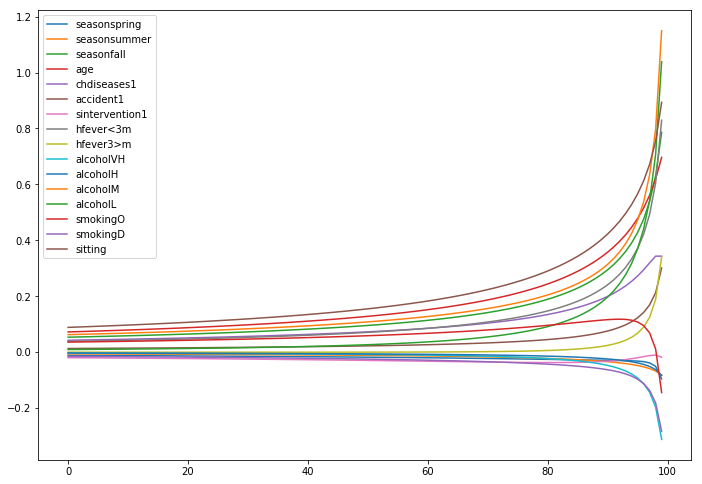

In [146]:
EXPONENTIAL_NOCONST.plot.line(figsize=(11.7, 8.27))

In [147]:
%%R -o EXPONENTIAL_ESTIMATOR
EXPONENTIAL_ESTIMATOR <- grid_search(expanded_training, EXPONENTIAL)
EXPONENTIAL_ESTIMATOR

[1] "Optimal regularization parameter"
[1] 0.02
[1] "Accuracy of the model"
[1] 0.8389831
     constant seasonspring seasonsummer seasonfall       age chdiseases1
100 -1.921685  -0.09646914  -0.08246223  0.7861394 0.6965034   0.3429353
    accident1 sintervention1 hfever<3m hfever3>m  alcoholVH   alcoholH alcoholM
100 0.3007358    -0.01869241 0.8295206  0.340486 -0.3127622 -0.0838949 1.150097
    alcoholL   smokingO  smokingD   sitting
100 1.039065 -0.1453742 -0.283487 0.8935299


/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning:

from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.



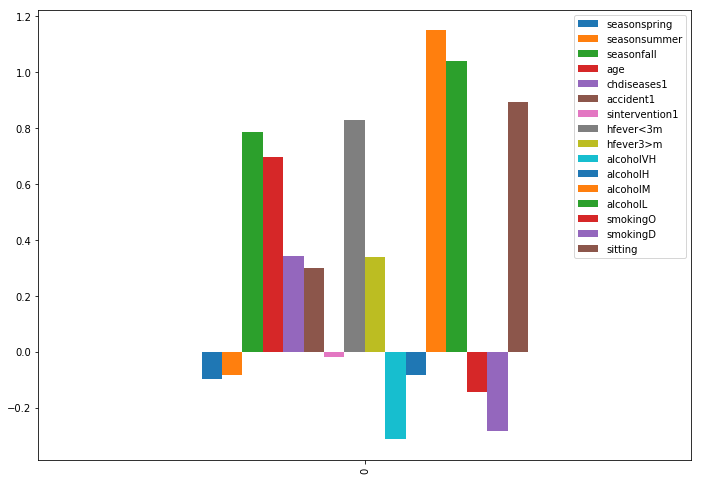

In [148]:
EXPONENTIAL_ESTIMATOR[EXPONENTIAL_ESTIMATOR.columns[1:]].plot.bar(figsize=(11.7, 8.27)) #Size of the betas

In [119]:
%%R
EXPONENTIAL_PREDICTION <- as.matrix(cbind(1, test[-ncol(test)]))%*%t(as.matrix(EXPONENTIAL_ESTIMATOR))
EXPONENTIAL_PREDICTION <- ifelse(EXPONENTIAL_PREDICTION >= 0, 1, -1)
confusionMatrix(as.factor(EXPONENTIAL_PREDICTION), as.factor(test$diagnosis), positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction -1  1
        -1 18  2
        1   8  2
                                          
               Accuracy : 0.6667          
                 95% CI : (0.4719, 0.8271)
    No Information Rate : 0.8667          
    P-Value [Acc > NIR] : 0.9989          
                                          
                  Kappa : 0.1176          
 Mcnemar's Test P-Value : 0.1138          
                                          
            Sensitivity : 0.50000         
            Specificity : 0.69231         
         Pos Pred Value : 0.20000         
         Neg Pred Value : 0.90000         
             Prevalence : 0.13333         
         Detection Rate : 0.06667         
   Detection Prevalence : 0.33333         
      Balanced Accuracy : 0.59615         
                                          
       'Positive' Class : 1               
                                          


The exponential loss have the same sensitivity but increases accuracy. Moreover, we can see different signs on the betas, although the same ranking of magnitudes (importance) remains. 

##### Logistic Loss using the Expanded Training Set

The function using logistic loss can be considered as a simplistic version of LogitBoost and, under certain conditions,is equal to the negative log-likelihood of a logistic regression. Nevertheless, by optimizing this function we are not modeling the conditional probabilities but directly the label of the observation.

In [149]:
%%R -o LOG_NOCONST
set.seed(134)
LOG <- regularization_graph(data = expanded_training, loss = log_loss)
LOG_NOCONST <- LOG[-1]

  seasonspring        seasonsummer         seasonfall           age         
 Min.   :-0.052156   Min.   :-0.078595   Min.   :0.02933   Min.   :0.03966  
 1st Qu.:-0.024047   1st Qu.:-0.013083   1st Qu.:0.03846   1st Qu.:0.05203  
 Median :-0.014422   Median :-0.007241   Median :0.05586   Median :0.07564  
 Mean   :-0.019213   Mean   :-0.012182   Mean   :0.09925   Mean   :0.13202  
 3rd Qu.:-0.010282   3rd Qu.:-0.005008   3rd Qu.:0.10224   3rd Qu.:0.13845  
 Max.   :-0.007986   Max.   :-0.003828   Max.   :0.78055   Max.   :0.95735  
  chdiseases1        accident1        sintervention1        hfever<3m      
 Min.   :0.02457   Min.   :0.007426   Min.   :-0.066965   Min.   :0.02035  
 1st Qu.:0.03201   1st Qu.:0.009664   1st Qu.:-0.037687   1st Qu.:0.02682  
 Median :0.04591   Median :0.013852   Median :-0.023754   Median :0.03932  
 Mean   :0.07501   Mean   :0.025889   Mean   :-0.029409   Mean   :0.07681  
 3rd Qu.:0.08140   3rd Qu.:0.024714   3rd Qu.:-0.017082   3rd Qu.:0.07370  
 Max.

/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning:

from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.



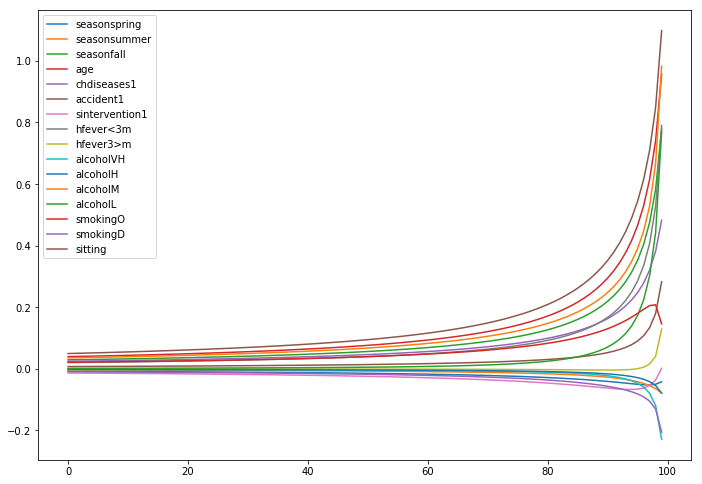

In [150]:
LOG_NOCONST.plot.line(figsize=(11.7, 8.27))

In [151]:
%%R -o LOG_ESTIMATOR
LOG_ESTIMATOR <- grid_search(expanded_training, LOG)
LOG_ESTIMATOR

[1] "Optimal regularization parameter"
[1] 0.02
[1] "Accuracy of the model"
[1] 0.8050847
     constant seasonspring seasonsummer seasonfall       age chdiseases1
100 -1.733179  -0.04188512  -0.07859488  0.7805464 0.9573509    0.482736
    accident1 sintervention1 hfever<3m hfever3>m  alcoholVH    alcoholH
100 0.2827875    0.001806864   0.79068 0.1293475 -0.2290342 -0.07897843
     alcoholM  alcoholL  smokingO   smokingD sitting
100 0.9825004 0.7699549 0.1459724 -0.2056836 1.09817


/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning:

from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.



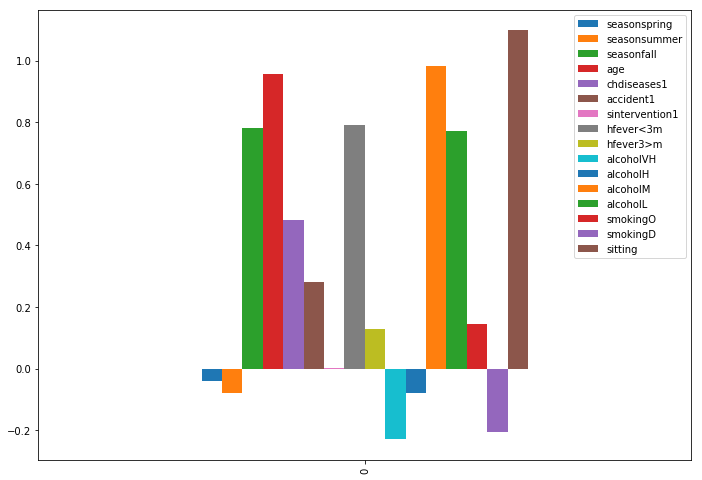

In [152]:
LOG_ESTIMATOR[LOG_ESTIMATOR.columns[1:]].plot.bar(figsize=(11.7, 8.27)) #Size of the betas

In [123]:
%%R
LOG_PREDICTION <- as.matrix(cbind(1, test[-ncol(test)]))%*%t(as.matrix(LOG_ESTIMATOR))
LOG_PREDICTION <- ifelse(LOG_PREDICTION >= 0, 1, -1)
confusionMatrix(as.factor(LOG_PREDICTION), as.factor(test$diagnosis), positive = "1")

Confusion Matrix and Statistics

          Reference
Prediction -1  1
        -1 17  2
        1   9  2
                                          
               Accuracy : 0.6333          
                 95% CI : (0.4386, 0.8007)
    No Information Rate : 0.8667          
    P-Value [Acc > NIR] : 0.99974         
                                          
                  Kappa : 0.0884          
 Mcnemar's Test P-Value : 0.07044         
                                          
            Sensitivity : 0.50000         
            Specificity : 0.65385         
         Pos Pred Value : 0.18182         
         Neg Pred Value : 0.89474         
             Prevalence : 0.13333         
         Detection Rate : 0.06667         
   Detection Prevalence : 0.36667         
      Balanced Accuracy : 0.57692         
                                          
       'Positive' Class : 1               
                                          


Logistic loss performs equally to the quadratic and the hinge loss models. 

**Summary of Simple Models Results**: 

Conclusively, we can see that although the models perform similarly, the exponential model outperforms the others in terms of accuracy, although all of them have the same recall. Moreover, we have identified the same pattern of relevance of the variables in all the models, being the more significant variables:

1. Sitting hours.
2. Alcohol Consumption.
3. High Fever in less than 3 months.
4. Smoking frequency.
5. Age

## Adaboost

The Adaboost algorithm was proposed by Freund & Schapire in 1997. As the other boosting algorithms, it tries to achieve a strong learning algorithm by mixing different weak algorithms giving some weight to each of them. 

As stated before, these weak learners correspond to the $h(X)$ function, and generally consist on a binary decision tree that performs slightly better than selecting at random the class of the observation. Therefore, in each iteration, weights are updated in such a way that misclassified elements in the previous iterations gain importance. Each weight represent the error of misclassification of that weak learner given by the exponential loss function.

<img src="https://cdn-images-1.medium.com/max/1600/0*paPv7vXuq4eBHZY7.png" alt="Italian Trulli">

Source: Medium.com, url: https://medium.com/diogo-menezes-borges/boosting-with-adaboost-and-gradient-boosting-9cbab2a1af81

In the case of Adaboost it tries to minimize a exponential loss function of the form:


$$
\sum_{i} w_i e^{-y_i(h(X)^t \beta + \beta_0)} 
$$
which is considered an upper bound of the indicator function misclassification error (Schapire & Singer 1998).

However it updates the weigths in such a way that misclassified observations have more relevace.

Finally, it is important to remark that the use of stumps (this binary trees with just two branches and nodes) as weak learners, reduces the bias and the variance of the predictions as stated by Freudman, Hastie and Tibshirani (2000).


**Pseudocode**

**Input**: Sequence of N labeled examples. Number of Iterations to be performed.

**Output**: The Strong learner as a weighted average of the weak learners.

**For** t in 1 to T:

$\quad$ Give to every observation the same weight 1/N

$\quad$ Find a weak learner h(X) that minimizes the error term of the form:

$$
\epsilon^{(t)} = \frac{\sum_{i}^{N} w_i^{(t)} 1_{[y_i \neq h(x_i)^{(t)}]}}{\sum_{i}^{N} w_i}
$$

$\quad$ Compute the betas as:

$$
\beta^{(t)} = log \frac{1-\epsilon^{(t)}}{\epsilon^{(t)}}
$$

$\quad$ Update the weight as:

$$
w_i^{(t+1)} \Leftarrow w_i^{(t)} e^{-y_i(h(X)^t \beta + \beta_0)} 
$$

$\quad$ Renormalize w_i

**Endfor**

**Return** Optimal $h(X)^t \beta + \beta_0$


Although this model is specific for discrete classes, it can be expanded to represent a real value probability by doing $h(x) = \frac{1}{2} log \frac{p(x)}{1-p(x)}$ (Friedman, Hastie and Tibshirani 2000). 

In [66]:
%%R
#transforming classes into factors
expanded_training$class <- as.factor(expanded_training$class)
levels(expanded_training$class) <- c("Normal","Altered")
# expanded_training$class <- as.logical(as.numeric(levels(expanded_training$class))[expanded_training$class])

In [67]:
%%R
training$diagnosis <- as.factor(training$diagnosis)
levels(training$diagnosis) <- c("Normal","Altered")

In [68]:
%%R
test$diagnosis <- as.factor(test$diagnosis)
levels(test$diagnosis) <- c("Normal","Altered")

In [69]:
%%R
set.seed(134)
#This Grid was optimal in the majority of the replications done
#Grid <- expand.grid(nIter = 50,
#                    method = "Real adaboost")

# We analyze with grid seach using internal cross validation
control <- trainControl(method = "repeatedcv", 
						number = 10, 
						repeats = 5)

model.training <- train(class ~ ., #Can take several seconds to compute
						data = expanded_training, 
                        trControl = control,
                       # tuneGrid = Grid,
						method = "adaboost")


In [109]:
%%R
print(model.training$finalModel)

fastAdaboost::real_adaboost(formula = .outcome ~ ., data = dat, 
    nIter = param$nIter)
.outcome ~ .
<environment: 0x7fecd0aad850>
Dependent Variable: .outcome
No of trees:50


AdaBoost Classification Trees 

118 samples
 16 predictor
  2 classes: 'Normal', 'Altered' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 106, 106, 106, 107, 107, 106, ... 
Resampling results across tuning parameters:

  nIter  method         Accuracy   Kappa    
   50    Adaboost.M1    0.8872145  0.7752728
   50    Real adaboost  0.9424825  0.8848167
  100    Adaboost.M1    0.8905711  0.7823501
  100    Real adaboost  0.9424825  0.8848167
  150    Adaboost.M1    0.8922378  0.7856835
  150    Real adaboost  0.9424825  0.8848167

Accuracy was used to select the optimal model using the largest value.
The final values used for the model were nIter = 50 and method = Real adaboost.


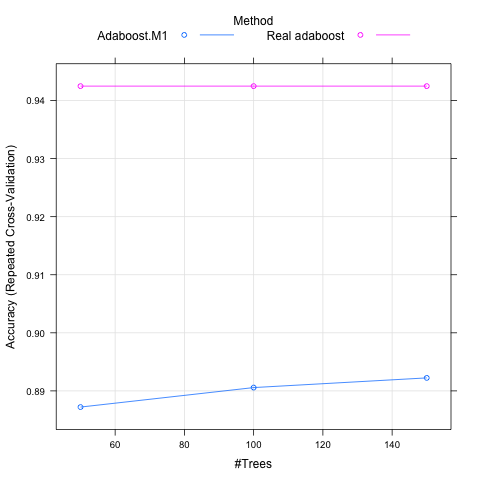

In [70]:
%%R
# Print basic information about our model.
print(model.training)


# The plot function can be used to examine the relationship between 
# the estimates of performance and the tuning parameters.
plot(model.training, log = "y")

As we can see, the preferred model is the real one over the discrete.

In [71]:
%%R
# Evaluate model on test set.
model.test.pred <- predict(model.training, 
						   test, 
						   type = "raw",
						   norm.votes = TRUE)

model.test.prob <- predict(model.training, 
						   test, 
						   type = "prob",
						   norm.votes = TRUE)

# Compute confusion matrix.
performance <- confusionMatrix(model.test.pred, test[, class], positive = "Altered")
print(performance)
print(performance$byClass)

Confusion Matrix and Statistics

          Reference
Prediction Normal Altered
   Normal      24       4
   Altered      2       0
                                          
               Accuracy : 0.8             
                 95% CI : (0.6143, 0.9229)
    No Information Rate : 0.8667          
    P-Value [Acc > NIR] : 0.9046          
                                          
                  Kappa : -0.0976         
 Mcnemar's Test P-Value : 0.6831          
                                          
            Sensitivity : 0.00000         
            Specificity : 0.92308         
         Pos Pred Value : 0.00000         
         Neg Pred Value : 0.85714         
             Prevalence : 0.13333         
         Detection Rate : 0.00000         
   Detection Prevalence : 0.06667         
      Balanced Accuracy : 0.46154         
                                          
       'Positive' Class : Altered         
                                          
         

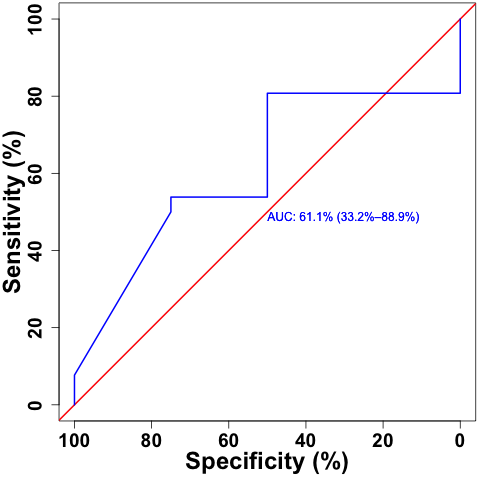

In [72]:
%%R
# Compute AUC for the model.
model.roc <- plot.roc(predictor = model.test.prob[,2],  
					  test[,class],
					  levels = rev(levels(test[,class])),
					  legacy.axes = FALSE,
					  percent = TRUE,
					  mar = c(4.1,4.1,0.2,0.3),
					  identity.col = "red",
					  identity.lwd = 2,
					  smooth = FALSE,
					  ci = TRUE, 
					  print.auc = TRUE,
					  auc.polygon.border=NULL,
					  lwd = 2,
					  cex.lab = 2.0, 
					  cex.axis = 1.6, 
					  font.lab = 2,
					  font.axis = 2,
					  col = "blue")


Although the algorithm predicts some altered observations it fails in detecting the correct ones. By changing the threshold (since we are using real adaboost which predicts probabilities), we obtain an AUC of 61% which is better than random selection but is quite low, considering that a good classifier have an AUC > 70%.

## Support Vector Machine (SVM)

The Support Vector Machine algorithm tries to build a hyperplane dividing the two classes in the feature space. To do so it minimizes a function of the form:

$$
\frac{1}{N}\sum_{i}max[0, 1-y_i(\varphi(X)^t \beta + \beta_0)] + \frac{\lambda}{2} \beta^t \beta
$$

Where $\varphi$ represents a kernel transformation applied to the data. 

The problem in fact, can be rewritten as:

$$
min_{\gamma, \beta, \beta_0} \frac{1}{2}\beta^t \beta + C \sum_{i=1}^{N} \xi
$$

such that:

$$
y_i(\varphi(X_i)^t \beta + \beta_0) \leq 1-\xi_i \\
\xi_i \geq 0
$$

Where the C parameter, as the $\lambda$ parameter, represent the size of the margin obtained, implying the tolerance of misclassification. Bigger values of C look for smaller margins improving classification, whereas small values of C imply larger margins although that may imply more misclassifications. Therefore, this parameter allow the algorithm to deal with non- linearly separable data.

Another tool to deal with this kind of issues is the kernel function $\varphi$. This function transform the feature space so that a linear separation might be possible. See next figure:


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/fe/Kernel_Machine.svg/2560px-Kernel_Machine.svg.png" alt="Italian Trulli">

Source: Wikipedia. URL: https://en.wikipedia.org/wiki/Support_vector_machine

#### Linear

Firstly, we tried the algorithm using the linear kernel, which doesn't apply any transformation to the feature space.

In [204]:
%%R
set.seed(134)
Grid <- expand.grid(C = c(0,0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2,5))
control <- trainControl(method = "repeatedcv", 
						number = 10, 
						repeats = 5)

model.training <- train(class ~ ., 
						data = expanded_training, 
                        trControl = control,
                        tuneGrid = Grid,
						method = "svmLinear")

In [205]:
%%R
# Print basic information about our model.
print(model.training)


Support Vector Machines with Linear Kernel 

118 samples
 16 predictor
  2 classes: 'Normal', 'Altered' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 106, 107, 106, 105, 106, 107, ... 
Resampling results across tuning parameters:

  C     Accuracy   Kappa    
  0.00        NaN        NaN
  0.01  0.7140676  0.4104499
  0.05  0.7301166  0.4573847
  0.10  0.7507226  0.5020182
  0.25  0.7781235  0.5597915
  0.50  0.8093473  0.6227670
  0.75  0.8243473  0.6531700
  1.00  0.8279604  0.6599509
  1.25  0.8329604  0.6699979
  1.50  0.8432867  0.6899434
  1.75  0.8466200  0.6966101
  2.00  0.8510839  0.7053451
  5.00  0.8576224  0.7186101

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was C = 5.


In [206]:
%%R
# Evaluate model on test set.
model.test.pred <- predict(model.training, 
						   test, 
						   type = "raw",
						   norm.votes = TRUE)

# Compute confusion matrix.
performance <- confusionMatrix(model.test.pred, test[, class], positive = "Altered")
print(performance)
print(performance$byClass)

Confusion Matrix and Statistics

          Reference
Prediction Normal Altered
   Normal      17       1
   Altered      9       3
                                          
               Accuracy : 0.6667          
                 95% CI : (0.4719, 0.8271)
    No Information Rate : 0.8667          
    P-Value [Acc > NIR] : 0.99889         
                                          
                  Kappa : 0.2187          
 Mcnemar's Test P-Value : 0.02686         
                                          
            Sensitivity : 0.7500          
            Specificity : 0.6538          
         Pos Pred Value : 0.2500          
         Neg Pred Value : 0.9444          
             Prevalence : 0.1333          
         Detection Rate : 0.1000          
   Detection Prevalence : 0.4000          
      Balanced Accuracy : 0.7019          
                                          
       'Positive' Class : Altered         
                                          
         

As we can see, the maximum C is selected, implying a smaller margin but better classification, this might imply that in fact, data might be difficult to separate linearly. Moreover, we can see a better performance than the Adaboost and the simple models, increasing the sensitivity from 50% to 75%, while keeping the same accuracy as the others.

#### Radial or Gaussian kernel

The Radial kernel of Gaussian kernel, transform the input feature space following the formula:

$$
K(x_i, x_j) = exp(- \frac{\lVert x_i - x_j \lVert^2}{2 \sigma^2})
$$

which is 1 when the points are close and 0 otherwise.

And we can recover the features since:

$$
K(x_i, x_j) = \varphi(x_i)^t\varphi(x_j)
$$

In [220]:
%%R
set.seed(134)
control <- trainControl(method = "repeatedcv", 
						number = 10, 
						repeats = 5)

model.training <- train(class ~ ., 
						data = expanded_training, 
                        trControl = control,
						method = "svmRadial")

Support Vector Machines with Radial Basis Function Kernel 

118 samples
 16 predictor
  2 classes: 'Normal', 'Altered' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 106, 106, 107, 107, 105, 107, ... 
Resampling results across tuning parameters:

  C     Accuracy   Kappa    
  0.25  0.7515385  0.4907189
  0.50  0.8001865  0.5966570
  1.00  0.8242890  0.6486602

Tuning parameter 'sigma' was held constant at a value of 0.03925763
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were sigma = 0.03925763 and C = 1.


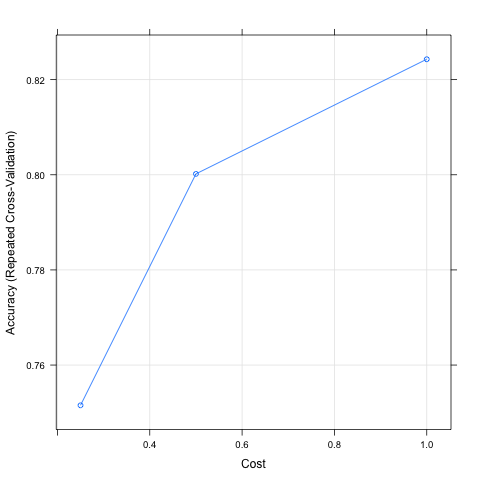

In [221]:
%%R
print(model.training)
plot(model.training)

In [222]:
%%R
# Evaluate model on test set.
model.test.pred <- predict(model.training, 
						   test, 
						   type = "raw",
						   norm.votes = TRUE)

# Compute confusion matrix.
performance <- confusionMatrix(model.test.pred, test[, class], positive = "Altered")
print(performance)
print(performance$byClass)

Confusion Matrix and Statistics

          Reference
Prediction Normal Altered
   Normal      22       4
   Altered      4       0
                                          
               Accuracy : 0.7333          
                 95% CI : (0.5411, 0.8772)
    No Information Rate : 0.8667          
    P-Value [Acc > NIR] : 0.9864          
                                          
                  Kappa : -0.1538         
 Mcnemar's Test P-Value : 1.0000          
                                          
            Sensitivity : 0.0000          
            Specificity : 0.8462          
         Pos Pred Value : 0.0000          
         Neg Pred Value : 0.8462          
             Prevalence : 0.1333          
         Detection Rate : 0.0000          
   Detection Prevalence : 0.1333          
      Balanced Accuracy : 0.4231          
                                          
       'Positive' Class : Altered         
                                          
         

However the radial kernel performs worst than the linear one, predicting erronous altered, reducing its recall and  accuracy.

#### Polynomial

The Polynomic kernel transform the input feature space following the formula:

$$
K(x_i, x_j) = (x_ix_j + c)^d
$$

where d is the polynomial degree and c the scale.

In [223]:
%%R
set.seed(134)
control <- trainControl(method = "repeatedcv", 
						number = 10, 
						repeats = 5)

model.training <- train(class ~ ., 
						data = expanded_training, 
                        trControl = control,
						method = "svmPoly")

Support Vector Machines with Polynomial Kernel 

118 samples
 16 predictor
  2 classes: 'Normal', 'Altered' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 106, 105, 106, 107, 106, 106, ... 
Resampling results across tuning parameters:

  degree  scale  C     Accuracy   Kappa    
  1       0.001  0.25  0.5258275  0.0000000
  1       0.001  0.50  0.5258275  0.0000000
  1       0.001  1.00  0.5258275  0.0000000
  1       0.010  0.25  0.5258275  0.0000000
  1       0.010  0.50  0.6363636  0.2414802
  1       0.010  1.00  0.7226923  0.4296643
  1       0.100  0.25  0.7232517  0.4403861
  1       0.100  0.50  0.7312587  0.4594540
  1       0.100  1.00  0.7403263  0.4818838
  2       0.001  0.25  0.5258275  0.0000000
  2       0.001  0.50  0.5258275  0.0000000
  2       0.001  1.00  0.5258275  0.0000000
  2       0.010  0.25  0.6553030  0.2840471
  2       0.010  0.50  0.7242075  0.4330850
  2       0.010  1.00  0.7284266  0.4484723
  2  

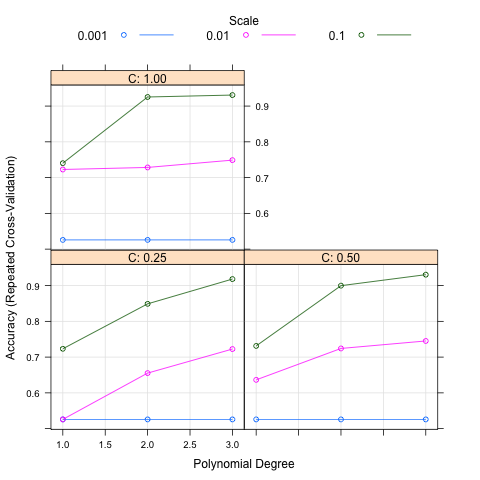

In [224]:
%%R
print(model.training)
plot(model.training)

In [225]:
%%R
# Evaluate model on test set.
model.test.pred <- predict(model.training, 
						   test, 
						   type = "raw",
						   norm.votes = TRUE)

# Compute confusion matrix.
performance <- confusionMatrix(model.test.pred, test[, class], positive = "Altered")
print(performance)
print(performance$byClass)

Confusion Matrix and Statistics

          Reference
Prediction Normal Altered
   Normal      24       4
   Altered      2       0
                                          
               Accuracy : 0.8             
                 95% CI : (0.6143, 0.9229)
    No Information Rate : 0.8667          
    P-Value [Acc > NIR] : 0.9046          
                                          
                  Kappa : -0.0976         
 Mcnemar's Test P-Value : 0.6831          
                                          
            Sensitivity : 0.00000         
            Specificity : 0.92308         
         Pos Pred Value : 0.00000         
         Neg Pred Value : 0.85714         
             Prevalence : 0.13333         
         Detection Rate : 0.00000         
   Detection Prevalence : 0.06667         
      Balanced Accuracy : 0.46154         
                                          
       'Positive' Class : Altered         
                                          
         

Similarly to the radial kernel, the algorithm predict erroneous altered samples, although it misses less normal ones. 

**Summary SVM**: 

Conclusively, we can say that until now the best performing algorithm in terms of recall is the SVM with the linear kernel. Moreover, it seems that transformations of the feature space tend to decrease the accuracy of the algorithm, probably because they add noise to the space defined by the SMOTE expansion. 

## LogitBoost:

LogitBoost, proposed by Friedman, Hastie & Tibshirani (2000) perform similar steps as the Adaboost, but rather than minimizing the exponential loss function, it minimizes the logistic loss function:

$$
log(1+e^{-y_i(h(X)^t \beta + \beta_0)})
$$

Moreover, here, the weak learners are added to predict a log-odds ratio rather than the $f(x)$ function:

$$
\frac{1}{2} log(\frac{P[y = 1 \vert x]}{P[y = -1 \vert x]}) = h(X)^t 1
$$

In fact, here the weights are updated in such a way that they reduce the variance of a Bernouilli distribution. 

**Pseudocode**

**Input**: Sequence of N labeled examples. Number of Iterations to be performed.

**Output**: The Strong learner as a weighted average of the weak learners.

**For** t in 1 to T:

$\quad$ Give to every observation the same weight 1/N, p(x) = 1/2, $\phi(X) = 0$

$\quad$ Update the weight as:

$$
w_i^{(t+1)} \Leftarrow p^{(t)}(1-p^{(t)})
$$

$$
z_i^{(t+1)} = \frac{y_i - p^{(t)}(x_i)}{w_i^{(t)}}
$$

$\quad$ Fit h(x) by weighted regression:

$$
h^{(t)}(x) = argmin_{h} \sum_{i=1}^{N} w_{i}^{(t)}(z_{i}^{t} - h(x_i))^2 
$$

$\quad$ Update $f(X)$:

$$
f(X)^{(t+1)} \Leftarrow f(X)^{(t)} + \frac{1}{2} h(X) 
$$

$\quad$ Update p(x):

$$
p(x) = \frac{e^{f(X)}}{e^{f(X)} + e^{-f(X)}}
$$

**Endfor**

**Return** Optimal $f(X)$ and $\phi(X) = sign(f(X))$

As we can see, LogitBoost can be summarized as a logistic regression using additively weak learners.

In [23]:
%%R
set.seed(134)
control <- trainControl(method = "repeatedcv", 
						number = 10, 
						repeats = 5)

model.training <- train(class ~ ., 
						data = expanded_training, 
                        trControl = control,
						method = "LogitBoost")

Boosted Logistic Regression 

118 samples
 16 predictor
  2 classes: 'Normal', 'Altered' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 107, 106, 107, 106, 106, 106, ... 
Resampling results across tuning parameters:

  nIter  Accuracy   Kappa    
  11     0.8339860  0.6669519
  21     0.8692075  0.7370717
  31     0.8770862  0.7532262

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was nIter = 31.


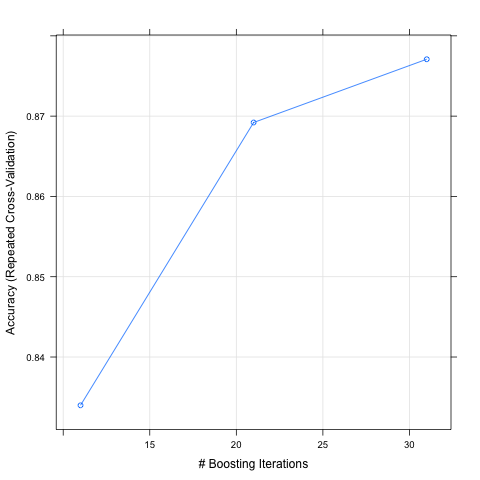

In [24]:
%%R
print(model.training)
plot(model.training)

In [25]:
%%R
# Evaluate model on test set.
model.test.pred <- predict(model.training, 
						   test, 
						   type = "raw",
						   norm.votes = TRUE)

# Compute confusion matrix.
performance <- confusionMatrix(model.test.pred, test[, class], positive = "Altered")
print(performance)
print(performance$byClass)

Confusion Matrix and Statistics

          Reference
Prediction Normal Altered
   Normal      21       2
   Altered      5       2
                                          
               Accuracy : 0.7667          
                 95% CI : (0.5772, 0.9007)
    No Information Rate : 0.8667          
    P-Value [Acc > NIR] : 0.9613          
                                          
                  Kappa : 0.2336          
 Mcnemar's Test P-Value : 0.4497          
                                          
            Sensitivity : 0.50000         
            Specificity : 0.80769         
         Pos Pred Value : 0.28571         
         Neg Pred Value : 0.91304         
             Prevalence : 0.13333         
         Detection Rate : 0.06667         
   Detection Prevalence : 0.23333         
      Balanced Accuracy : 0.65385         
                                          
       'Positive' Class : Altered         
                                          
         

LogitBoost seems to have the best balance between accuracy and recall, being able to detect half of the altered samples without misclassifying too many normal samples.

### Logistic Regression

Finally, we decided to fit a logistic regression whose negative log-likelihood can be shown to be the function optimized by the large margin classifier with logistic loss function. 

In [73]:
%%R
levels(expanded_training$class) <- c("0", "1") #We change the class labels so that they can be used in the glm function
expanded_training$class <- as.numeric(levels(expanded_training$class))[expanded_training$class]

In [74]:
%%R
levels(test$diagnosis) <- c("0", "1")
test$diagnosis <- as.numeric(levels(test$diagnosis))[test$diagnosis]

In [75]:
%%R
modellog <- glm(class ~ ., family=binomial(link="logit"), data = expanded_training)
summary(modellog)


Call:
glm(formula = class ~ ., family = binomial(link = "logit"), data = expanded_training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.0573  -0.1967  -0.0002   0.6948   1.1521  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -10.8771     3.1709  -3.430 0.000603 ***
seasonspring        -1.3836     1.5438  -0.896 0.370157    
seasonsummer        -5.4908  2648.3347  -0.002 0.998346    
seasonfall           2.6806     1.1493   2.332 0.019686 *  
age                  2.9791     1.0617   2.806 0.005015 ** 
chdiseases1         -0.8091     1.2136  -0.667 0.504944    
accident1            1.7150     1.0553   1.625 0.104144    
sintervention1      -0.5784     0.8706  -0.664 0.506461    
hfevermore3m         6.2054     2.1075   2.944 0.003236 ** 
hfeverless3m         4.4376     1.8538   2.394 0.016677 *  
alcoholVeryHigh    -16.9619  3956.1808  -0.004 0.996579    
alcoholHigh         -8.2787  3956.1817  -0.002 0.998330   

In [77]:
%%R 
predictions <-round(predict(modellog, test, type = "response"), 0)


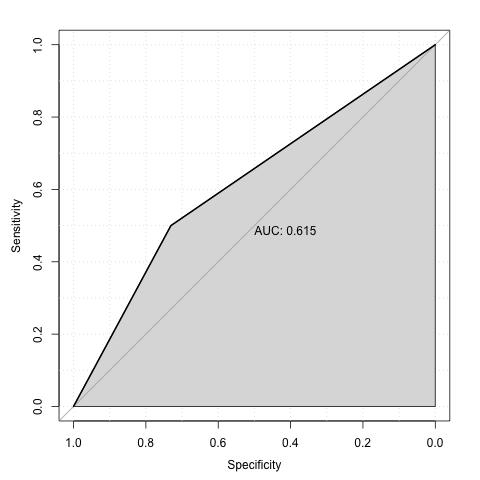

In [78]:
%%R
pROC::plot.roc(test$diagnosis, predictions,
              print.auc = TRUE,
              grid = TRUE,
              auc.polygon = TRUE)

In [79]:
%%R
confusionMatrix(as.factor(predictions), as.factor(test[, class]))

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 19  2
         1  7  2
                                         
               Accuracy : 0.7            
                 95% CI : (0.506, 0.8527)
    No Information Rate : 0.8667         
    P-Value [Acc > NIR] : 0.9958         
                                         
                  Kappa : 0.1509         
 Mcnemar's Test P-Value : 0.1824         
                                         
            Sensitivity : 0.7308         
            Specificity : 0.5000         
         Pos Pred Value : 0.9048         
         Neg Pred Value : 0.2222         
             Prevalence : 0.8667         
         Detection Rate : 0.6333         
   Detection Prevalence : 0.7000         
      Balanced Accuracy : 0.6154         
                                         
       'Positive' Class : 0              
                                         


Finally, as expected, the logistic regression performs equally to the simple large margin classifier model with logistic loss, moreover, the AUC is the same as the one of the Real Adaboost. Nevertheless, coefficients differ, probably because of the regularization parameter of the large margin classifier.

## Conclusion

Conclusively, SVM with linear kernel might be the algorithm selected if our objective is to maximize recall, whereas LogitBoost is a great balanced option that achieve a decent recall while keeping good accuracy. It is important to remark that simple algorithms as the basic ones, which just optimized different loss functions, can achieve better results than sophisticated algorithms as AdaBoost or SVM with radial or polynomial kernel, in fact, they obtained results similar to the one of logistic regression. This result is supported by the work of Lee (2012) which states that "modeling at least the conditional probability helps use data more efficiently than maximizing classification margins under the hinge loss or the exponential loss". Moreover, as it is also stated in his work, SVM tend to be more efficient than boosting (as seen by the computation time and the resulst of linear SVM and Adaboost) when many observations lay on the boundary between the classes and data is almost linearly separable. 

Possible expansions for this project could be:

1. Trying different regularization functions apart from Ridge (square of the norm).
2. Implement a regularization parameter which punish grouped categorical variables rather than individual ones (Grouped LASSO) as proposed by Yang and Zou (2015).
3. Implement more variations of the boosting algorithms as the XGboost. 
4. Trying different variations of the SMOTE technique such as ADASYN or Safe-SMOTE.
5. Given a bigger fragment of the dataset we could combine over-sampling of the minority class using SMOTE with under sampling of the majority class using Ripper since, as stated by Chawla, this combination improve even more the learning of the algorithms.




## References

Altun Y., Hofman T. Large Margin Methods for Label Sequence Learning. INTERSPEECH, 2003.

Chawla N., Bowyer K., Hall L., Kegelmeyer W. SMOTE: Synthetic Minority Over-Sample Technique. Journal of Artificial Intelligence Research Vol. 16, 321–357, 2002.

Friedman J., Hastie T., Tibshirani R. Additive Logistic Regression: A Statistical View of Boosting. The Annals of Statistics Vol. 20, Issue 2, 337-407, 2000.

Freund Y., Schapire R. A Short Introduction to Boosting. Journal of Japanese Society for Artificial Intelligence Vol. 14, Issue 5, 771-780, 1999.

Freund Y., Schapire R. A decision-theoretic generalization of on-line learning and an application to boosting. Journal of Computer and System Sciences Vol. 55, Issue 1, 119–139, 1997.

Gil D., Girela J., Juan J., Gomez-Torres M., Johnsson M. Predicting seminal quality with artificial intelligence methods. Expert Systems with Applications Vol. 39, 12546 -12573, 2012. 

Lee Y. Smooth Support Vector Machines. University of Winsconsin. 2000.

Lee Y., Wang R. Does modeling lead tomore accurate classification?:  A study of relative efficiency in linear classification. Technical Report No. 869, 2012.

Smola A., Bartlett P., Scholkopf B., Schuurmans D. Advances in Large Margin Classifiers. The MIT Press. 1999.

Smola A. Scholkopf B. On a Kernel􏰁based Metho d for Pattern Recognition􏰀 Regression􏰀 Approximation􏰀 and Operator Inversion. Algorithmica Vol. 22, Issue 1, 211-231, 1998. 

Tzelepis C., Mezaris V., Patras I. Linear Maximum Margin Classifier for Learning from Uncertain Data. IEEE Transactions on Pattern Analysis and Machine Intelligence Vol. 40, Issue 12, 2948 - 2962, 2017.

Yang Y., Zou H. A Fast Unified Algorithm for Solving Group-Lasso Penalized Learning Problems. Statistics and Computing Vol. 25, Issue 6, 1129–1141, 2015.


